In [1]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import scipy.optimize as spo
import Utils

from StockDataSource import YahooDataSource
from StockPricePredictor import StockPricePredictor

import seaborn as sns
from Portfolio import Portfolio 

%matplotlib inline

In [6]:
ticker_symbols = ['IBM', 'GLD', 'AAPL', 'SPY']
start = datetime(2014, 1, 4)
end = datetime(2016, 1, 4)

predictor = StockPricePredictor()
df, normalized = predictor.fit(ticker_symbols, start, end)

In [191]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

In [197]:
RANDOM_STATE = 314

test_ratio = 0.6
window_size_days = 30
df = normalized['IBM'].reset_index(drop=True)
train_span = int(df.shape[0] * test_ratio)
test_span = int(df.shape[0] * (1-test_ratio))

def build_data(df, window_size, examples, index_shift=0):
    X = []
    for start_index in range(examples - window_size):
        x1 = start_index + index_shift
        x2 = x1 + window_size
        X.append(df.iloc[x1:x2].reset_index(drop=True))    
    return X

X_train = build_data(df, window_size_days, train_span, 0)
X_test = build_data(df, window_size_days, test_span, train_span)
    
n_components = 12

X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train.shape)
print(X_test.shape)

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True)
pca = pca.fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

(271L, 30L)
(171L, 30L)
Extracting the top 12 eigenfaces from 271 faces
done in 0.002s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.000s


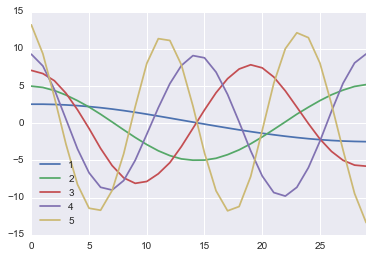

In [198]:
if hasattr(pca, 'cluster_centers_'):
    components_ = pca.cluster_centers_
else:
    components_ = pca.components_

classified = components_[:n_components]
found = pd.DataFrame(classified)
found = found.transpose()
_ = found[[1, 2, 3, 4, 5]].plot()

In [199]:
from sklearn.metrics import mean_squared_error
from math import sqrt

ratio = 0.6

def error_fun(oscilator, series):    
    samples = oscilator.shape[0]*ratio
    oscilator_sample = oscilator[0:samples]
    series_sample = series[0:samples]
    return sqrt(mean_squared_error(series_sample, oscilator_sample))

def calc_error(oscilatorsDf, series):
    df = pd.DataFrame(columns=oscilatorsDf.columns)
    for col in oscilatorsDf.columns.values:
        oscilator = oscilatorsDf[col].values
        df[col] = pd.Series(error_fun(oscilator, series))
    return df
        
def best_oscilator_col(errorDf):
    best = 'NaN'
    bestVal = 0
    for col in errorDf.columns.values:
        if best == 'NaN':
            best = col
            bestVal = errorDf[best][0]
        elif bestVal > errorDf[col][0]:
            best = col
            bestVal = errorDf[best][0]
    return best

def get_sell_index(oscilator):
    series = oscilator.transpose().values
    start_index = oscilator.shape[0]*ratio
    start_val = series[start_index]
    max_index = np.array(series[start_index:], dtype=float).argmax()
    max_val = series[max_index]
    if(max_val > start_val*1.1):
        return max_index
    else: 
        return -1
        
rows_count = df.shape[0] - window_size_days
used_oscilator = -1

shares = 0
cash = 1000
sell_index = -1

predictor = StockPricePredictor()
real, normalized = predictor.fit(ticker_symbols, start, end)
real = real['IBM'].reset_index(drop=True)

for i in range(rows_count):
    from_index = i
    to_index = from_index + window_size_days
    
    
    series = df[from_index:to_index].reset_index(drop=True).values
    if(used_oscilator == -1):
        errorDf = calc_error(found, series)
        used_oscilator = best_oscilator_col(errorDf)
        oscilator = found[used_oscilator]
        print("Analyzing {}, best oscilator: {}, with error: {}".format(i, used_oscilator, errorDf[used_oscilator]))
        series_sell_index = get_sell_index(oscilator)
        sell_index = from_index + series_sell_index
        if series_sell_index <= 0:
            used_oscilator = -1
            continue
            
        share_cost = real[i]
        shares = share_cost/cash
        print("Buying {} shares for {} price (oscilator: {}) at: {}. Cash: {}. Sell at: {}".format(shares, share_cost, used_oscilator, i, cash, sell_index))
        cash = 0
        break
    elif used_oscilator != -1 and i == sell_index:
        share_cost = real[i]
        cash = share_cost * shares
        print("Selling {} shares for {} price (oscilator: {}) at: {}. Cash: {}".format(shares, share_cost, used_oscilator, i, cash))
        shares = 0
        used_oscilator = -1
        

print("Cash: {}, shares: {}".format(cash, shares))

Analyzing 0, best oscilator: 1, with error: 0    1.098136
Name: 1, dtype: float64
Analyzing 1, best oscilator: 1, with error: 0    1.096894
Name: 1, dtype: float64
Analyzing 2, best oscilator: 1, with error: 0    1.096339
Name: 1, dtype: float64
Analyzing 3, best oscilator: 1, with error: 0    1.096015
Name: 1, dtype: float64
Analyzing 4, best oscilator: 1, with error: 0    1.097006
Name: 1, dtype: float64
Analyzing 5, best oscilator: 1, with error: 0    1.099347
Name: 1, dtype: float64
Analyzing 6, best oscilator: 1, with error: 0    1.102164
Name: 1, dtype: float64
Analyzing 7, best oscilator: 1, with error: 0    1.106094
Name: 1, dtype: float64
Analyzing 8, best oscilator: 1, with error: 0    1.112215
Name: 1, dtype: float64
Analyzing 9, best oscilator: 1, with error: 0    1.119012
Name: 1, dtype: float64
Analyzing 10, best oscilator: 1, with error: 0    1.1269
Name: 1, dtype: float64
Analyzing 11, best oscilator: 1, with error: 0    1.134525
Name: 1, dtype: float64
Analyzing 12, be

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
